In [5]:
!pip install open3d

  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.2 MB/s  0:02:31m0:00:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 11.4 MB/s  0:00:00 eta 0:00:01
Using cached flask-3.1.2-py3-none-any.whl (103 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 11.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s  0:00:00
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 11.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20/20 [open3d]19/20 [open3d]s]


In [6]:
# CELL 3 — VERIFY PACKAGES (run AFTER kernel restart)

import torch, numpy as np, sklearn
import open3d as o3d
from plyfile import PlyData

print("torch version      :", torch.__version__)
print("cuda available     :", torch.cuda.is_available())
print("cuda version       :", torch.version.cuda if torch.cuda.is_available() else None)
print("numpy version      :", np.__version__)
print("sklearn version    :", sklearn.__version__)
print("open3d version     :", o3d.__version__)
print("plyfile            : OK")

# Set DEVICE for later training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDEVICE =", DEVICE)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
torch version      : 2.9.0+cu128
cuda available     : True
cuda version       : 12.8
numpy version      : 2.2.6
sklearn version    : 1.7.2
open3d version     : 0.19.0
plyfile            : OK

DEVICE = cuda


In [7]:
# CELL 4 — PLY Dataset Loader (for your 3-class dataset)

import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path
from plyfile import PlyData

DATA_DIR = Path("/home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi")

label_map = {1: 0, 3: 1, 9: 2}   # final correct mapping

def read_ply_hungary(path):
    pd = PlyData.read(str(path))
    v = pd["vertex"].data

    pts = np.vstack([v["x"], v["y"], v["z"]]).T.astype(np.float32)
    labels = np.array(v["scalar_NewClassification"]).astype(np.int64)

    # remap labels
    labels = np.vectorize(lambda x: label_map.get(int(x), 255))(labels)
    mask = labels != 255
    return pts[mask], labels[mask]

class HungaryPLYDataset(Dataset):
    def __init__(self, root, files, points_per_sample=2048, augment=True):
        self.root = Path(root)
        self.files = files
        self.points_per_sample = points_per_sample
        self.augment = augment

    def __len__(self):
        return len(self.files) * 10

    def __getitem__(self, idx):
        ply = self.files[np.random.randint(len(self.files))]
        pts, labels = read_ply_hungary(self.root / ply)

        N = len(pts)
        P = self.points_per_sample
        idxs = np.random.choice(N, P, replace=(N < P))

        pts = pts[idxs]
        labels = labels[idxs]

        if self.augment:
            theta = np.random.uniform(0, 2 * np.pi)
            R = np.array([
                [np.cos(theta), -np.sin(theta), 0],
                [np.sin(theta),  np.cos(theta), 0],
                [0, 0, 1]
            ], dtype=np.float32)
            pts = pts @ R.T
            pts += np.random.normal(0, 0.01, pts.shape)

        pts -= pts.mean(0, keepdims=True)

        return torch.from_numpy(pts), torch.from_numpy(labels)

def collate_batch(batch):
    pts = torch.stack([b[0] for b in batch], dim=0)
    lbl = torch.stack([b[1] for b in batch], dim=0)
    return pts, lbl

# Create train/val split
all_files = sorted([f.name for f in DATA_DIR.glob("*.ply")])
import random
random.shuffle(all_files)
N = len(all_files)
train_files = all_files[:int(0.8*N)]
val_files = all_files[int(0.8*N):]




train_ds = HungaryPLYDataset(DATA_DIR, train_files, points_per_sample=1024, augment=True)
val_ds   = HungaryPLYDataset(DATA_DIR, val_files,   points_per_sample=1024, augment=False)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,
                          num_workers=0, collate_fn=collate_batch, pin_memory=True)

val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False,
                          num_workers=0, collate_fn=collate_batch, pin_memory=True)
print("train batches:", len(train_loader), "val batches:", len(val_loader))


train batches: 120 val batches: 40


In [ ]:
# CELL 5 — FIXED KPConv-Like Model (Dimension-Safe)

import torch
import torch.nn as nn
import torch.nn.functional as F

def knn(pts, K=8):
    """
    pts: (B, P, 3)
    returns idx: (B, P, K)
    """
    dist = torch.cdist(pts, pts)  # (B, P, P)
    idx = dist.topk(K, largest=False)[1]  # (B, P, K)
    return idx

class KPConvLayer(nn.Module):
    def __init__(self, in_c, out_c, K=8):
        super().__init__()
        self.K = K
        self.mlp = nn.Sequential(
            nn.Linear(in_c + 3, out_c),
            nn.ReLU(),
            nn.Linear(out_c, out_c)
        )

    def forward(self, pts, feats):
        """
        pts:   (B, P, 3)
        feats: (B, P, C)
        output: (B, P, out_c)
        """
        B, P, C = feats.shape
        K = self.K

        idx = knn(pts, K)         # (B, P, K)

        # gather neighbor coords: (B, P, K, 3)
        pts_expand = pts.unsqueeze(2).expand(B, P, K, 3)
        neigh_pts = torch.gather(pts.unsqueeze(1).expand(B, P, P, 3), 
                                 2, 
                                 idx.unsqueeze(-1).expand(B, P, K, 3))

        # gather neighbor feats: (B, P, K, C)
        feats_expand = feats.unsqueeze(1).expand(B, P, P, C)
        neigh_feats = torch.gather(feats_expand,
                                   2,
                                   idx.unsqueeze(-1).expand(B, P, K, C))

        # compute relative positions
        rel = neigh_pts - pts_expand  # (B,P,K,3)

        # concatenate features: (B,P,K, 3+C)
        inp = torch.cat([rel, neigh_feats], dim=-1)

        # MLP → (B,P,K,out_c)
        out = self.mlp(inp)

        # Max over K neighbors → (B,P,out_c)
        out = out.max(dim=2)[0]

        return out


class KPNet(nn.Module):
    def __init__(self, base=16, num_classes=3, K=8):
        super().__init__()
        self.fc0 = nn.Linear(3, base)

        self.kp1 = KPConvLayer(base, base*2, K)
        self.kp2 = KPConvLayer(base*2, base*4, K)

        self.head = nn.Sequential(
            nn.Linear(base*4, base*4),
            nn.ReLU(),
            nn.Linear(base*4, num_classes)
        )

    def forward(self, pts):
        feats = F.relu(self.fc0(pts))
        feats = self.kp1(pts, feats)
        feats = self.kp2(pts, feats)
        out = self.head(feats)
        return out

model = KPNet(base=8, num_classes=3, K=6).to(DEVICE)
model


KPNet(
  (fc0): Linear(in_features=3, out_features=8, bias=True)
  (kp1): KPConvLayer(
    (mlp): Sequential(
      (0): Linear(in_features=11, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (kp2): KPConvLayer(
    (mlp): Sequential(
      (0): Linear(in_features=19, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (head): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [9]:
# Sanity Test — Forward + Backward on 1 batch
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

pts, lbl = next(iter(train_loader))
pts, lbl = pts.to(DEVICE), lbl.to(DEVICE)

optimizer.zero_grad()
out = model(pts)
loss = criterion(out.view(-1,3), lbl.view(-1))
loss.backward()
optimizer.step()

print("Sanity OK — loss =", loss.item())


Sanity OK — loss = 1.1608850955963135


In [10]:
#cell6 new version
# --- IMPORTS ---
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import os
from sklearn.metrics import confusion_matrix

# --- SETUP ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SAVE_DIR = "./checkpoints_kpconv_24nov"
os.makedirs(SAVE_DIR, exist_ok=True)

LOG_FILE = os.path.join(SAVE_DIR, "training_log_24nov.csv")

# create log header
with open(LOG_FILE, "w") as f:
    f.write("epoch,train_loss,val_loss,iou0,iou1,iou2,miou\n")


# --- IoU Function ---
def compute_iou(pred, gt, nc):
    cm = confusion_matrix(gt, pred, labels=list(range(nc)))
    ious = []
    for i in range(nc):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        denom = tp + fp + fn
        ious.append(tp / denom if denom > 0 else 0)
    return np.array(ious)


# --- MODEL, OPT, LOSS ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 30        # train longer than before
best_miou = 0.0


# --- TRAINING LOOP ---
for ep in range(EPOCHS):

    # ========== TRAIN ==========
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {ep+1}/{EPOCHS}", leave=True)
    total_train_loss = 0
    batches = 0

    for pts, lbl in loop:
        pts, lbl = pts.to(DEVICE), lbl.to(DEVICE)

        optimizer.zero_grad()
        logits = model(pts)
        loss = criterion(logits.view(-1,3), lbl.view(-1))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        batches += 1
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / batches

    # ========== VALIDATION ==========
    model.eval()
    preds_all, lbl_all = [], []
    total_val_loss = 0
    val_batches = 0

    with torch.no_grad():
        for pts, lbl in val_loader:
            pts = pts.to(DEVICE)
            lbl = lbl.to(DEVICE)
            logits = model(pts)

            loss = criterion(logits.view(-1,3), lbl.view(-1))
            total_val_loss += loss.item()
            val_batches += 1

            pred = logits.argmax(-1).cpu().numpy().reshape(-1)
            lbl_np = lbl.cpu().numpy().reshape(-1)

            preds_all.append(pred)
            lbl_all.append(lbl_np)

    avg_val_loss = total_val_loss / val_batches

    preds_all = np.concatenate(preds_all)
    lbl_all = np.concatenate(lbl_all)

    iou = compute_iou(preds_all, lbl_all, 3)
    miou = iou.mean()

    print(f"\nEpoch {ep+1} Summary:")
    print(f"  Train Loss = {avg_train_loss:.4f}")
    print(f"  Val Loss   = {avg_val_loss:.4f}")
    print(f"  IoU        = {iou}")
    print(f"  mIoU       = {miou:.4f}")

    # ----- SAVE LOG -----
    with open(LOG_FILE, "a") as f:
        f.write(f"{ep+1},{avg_train_loss:.4f},{avg_val_loss:.4f},{iou[0]:.4f},{iou[1]:.4f},{iou[2]:.4f},{miou:.4f}\n")

    # ----- SAVE BEST MODEL -----
    if miou > best_miou:
        best_miou = miou
        best_path = os.path.join(SAVE_DIR, f"best_model_24nov_mIoU_{best_miou:.4f}.pth")
        torch.save(model.state_dict(), best_path)
        print(f"  ✅ Saved BEST model to {best_path}")

    # ----- OPTIONAL: SAVE EVERY CHECKPOINT -----
    ckpt_path = os.path.join(SAVE_DIR, f"checkpoint_epoch_{ep+1}_24nov.pth")
    torch.save(model.state_dict(), ckpt_path)


print("\n🎉 TRAINING COMPLETE!")
print("Best mIoU =", best_miou)


Epoch 1/30: 100%|██████████| 120/120 [14:54<00:00,  7.45s/it, loss=0.378]



Epoch 1 Summary:
  Train Loss = 0.7463
  Val Loss   = 0.4349
  IoU        = [0.88291016 0.         0.        ]
  mIoU       = 0.2943
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.2943.pth


Epoch 2/30: 100%|██████████| 120/120 [15:42<00:00,  7.85s/it, loss=0.457]



Epoch 2 Summary:
  Train Loss = 0.5536
  Val Loss   = 0.3709
  IoU        = [8.91864837e-01 0.00000000e+00 6.19195046e-04]
  mIoU       = 0.2975
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.2975.pth


Epoch 3/30: 100%|██████████| 120/120 [14:40<00:00,  7.34s/it, loss=0.235]



Epoch 3 Summary:
  Train Loss = 0.3604
  Val Loss   = 0.2861
  IoU        = [0.8835499 0.        0.1642378]
  mIoU       = 0.3493
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.3493.pth


Epoch 4/30: 100%|██████████| 120/120 [15:12<00:00,  7.60s/it, loss=0.177]



Epoch 4 Summary:
  Train Loss = 0.2436
  Val Loss   = 0.2009
  IoU        = [0.9459927  0.         0.83456425]
  mIoU       = 0.5935
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.5935.pth


Epoch 5/30: 100%|██████████| 120/120 [15:18<00:00,  7.65s/it, loss=0.191]



Epoch 5 Summary:
  Train Loss = 0.1986
  Val Loss   = 0.2147
  IoU        = [0.94121715 0.         0.75455158]
  mIoU       = 0.5653


Epoch 6/30: 100%|██████████| 120/120 [15:27<00:00,  7.73s/it, loss=0.23]  



Epoch 6 Summary:
  Train Loss = 0.1794
  Val Loss   = 0.2376
  IoU        = [0.93103917 0.         0.77154532]
  mIoU       = 0.5675


Epoch 7/30: 100%|██████████| 120/120 [15:12<00:00,  7.60s/it, loss=0.174] 



Epoch 7 Summary:
  Train Loss = 0.1813
  Val Loss   = 0.2242
  IoU        = [0.9315112  0.         0.73560028]
  mIoU       = 0.5557


Epoch 8/30: 100%|██████████| 120/120 [15:21<00:00,  7.68s/it, loss=0.105] 



Epoch 8 Summary:
  Train Loss = 0.1641
  Val Loss   = 0.2360
  IoU        = [0.91823831 0.00230415 0.76006273]
  mIoU       = 0.5602


Epoch 9/30: 100%|██████████| 120/120 [16:21<00:00,  8.18s/it, loss=0.171] 



Epoch 9 Summary:
  Train Loss = 0.1518
  Val Loss   = 0.1796
  IoU        = [0.93587736 0.00325945 0.83614146]
  mIoU       = 0.5918


Epoch 10/30: 100%|██████████| 120/120 [15:17<00:00,  7.64s/it, loss=0.0644]



Epoch 10 Summary:
  Train Loss = 0.1393
  Val Loss   = 0.2000
  IoU        = [0.92301717 0.01469788 0.65551744]
  mIoU       = 0.5311


Epoch 11/30: 100%|██████████| 120/120 [16:07<00:00,  8.06s/it, loss=0.15]  



Epoch 11 Summary:
  Train Loss = 0.1213
  Val Loss   = 0.1684
  IoU        = [0.93485893 0.13318617 0.6280654 ]
  mIoU       = 0.5654


Epoch 12/30: 100%|██████████| 120/120 [15:24<00:00,  7.70s/it, loss=0.0512]



Epoch 12 Summary:
  Train Loss = 0.1069
  Val Loss   = 0.1467
  IoU        = [0.94813837 0.59572845 0.67977654]
  mIoU       = 0.7412
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.7412.pth


Epoch 13/30: 100%|██████████| 120/120 [15:22<00:00,  7.69s/it, loss=0.107] 



Epoch 13 Summary:
  Train Loss = 0.0993
  Val Loss   = 0.1081
  IoU        = [0.96423447 0.55106707 0.80689655]
  mIoU       = 0.7741
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.7741.pth


Epoch 14/30: 100%|██████████| 120/120 [14:33<00:00,  7.28s/it, loss=0.148] 



Epoch 14 Summary:
  Train Loss = 0.1013
  Val Loss   = 0.1166
  IoU        = [0.95975438 0.57255747 0.81409602]
  mIoU       = 0.7821
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.7821.pth


Epoch 15/30: 100%|██████████| 120/120 [14:51<00:00,  7.43s/it, loss=0.155] 



Epoch 15 Summary:
  Train Loss = 0.0836
  Val Loss   = 0.1480
  IoU        = [0.95079528 0.55997211 0.71409153]
  mIoU       = 0.7416


Epoch 16/30: 100%|██████████| 120/120 [15:43<00:00,  7.86s/it, loss=0.0814]



Epoch 16 Summary:
  Train Loss = 0.0882
  Val Loss   = 0.1142
  IoU        = [0.96224458 0.58549223 0.83976652]
  mIoU       = 0.7958
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.7958.pth


Epoch 17/30: 100%|██████████| 120/120 [14:35<00:00,  7.30s/it, loss=0.0238]



Epoch 17 Summary:
  Train Loss = 0.0852
  Val Loss   = 0.1077
  IoU        = [0.96335202 0.59725086 0.68552775]
  mIoU       = 0.7487


Epoch 18/30: 100%|██████████| 120/120 [14:43<00:00,  7.37s/it, loss=0.0861]



Epoch 18 Summary:
  Train Loss = 0.0919
  Val Loss   = 0.1200
  IoU        = [0.95927963 0.57567746 0.80562827]
  mIoU       = 0.7802


Epoch 19/30: 100%|██████████| 120/120 [15:04<00:00,  7.54s/it, loss=0.0413]



Epoch 19 Summary:
  Train Loss = 0.0802
  Val Loss   = 0.1358
  IoU        = [0.95232834 0.56406869 0.76578371]
  mIoU       = 0.7607


Epoch 20/30: 100%|██████████| 120/120 [15:04<00:00,  7.54s/it, loss=0.0285]



Epoch 20 Summary:
  Train Loss = 0.0807
  Val Loss   = 0.1381
  IoU        = [0.95740643 0.60883534 0.65679953]
  mIoU       = 0.7410


Epoch 21/30: 100%|██████████| 120/120 [15:23<00:00,  7.69s/it, loss=0.0587]



Epoch 21 Summary:
  Train Loss = 0.0769
  Val Loss   = 0.0987
  IoU        = [0.9698219  0.70633105 0.82736602]
  mIoU       = 0.8345
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.8345.pth


Epoch 22/30: 100%|██████████| 120/120 [15:04<00:00,  7.54s/it, loss=0.0624]



Epoch 22 Summary:
  Train Loss = 0.0792
  Val Loss   = 0.1003
  IoU        = [0.96823582 0.66396214 0.85041667]
  mIoU       = 0.8275


Epoch 23/30: 100%|██████████| 120/120 [14:32<00:00,  7.27s/it, loss=0.0743]



Epoch 23 Summary:
  Train Loss = 0.0843
  Val Loss   = 0.1056
  IoU        = [0.96574059 0.63908046 0.76715003]
  mIoU       = 0.7907


Epoch 24/30: 100%|██████████| 120/120 [15:09<00:00,  7.58s/it, loss=0.0207]



Epoch 24 Summary:
  Train Loss = 0.0800
  Val Loss   = 0.1041
  IoU        = [0.96860239 0.6772692  0.84011568]
  mIoU       = 0.8287


Epoch 25/30: 100%|██████████| 120/120 [14:40<00:00,  7.34s/it, loss=0.124] 



Epoch 25 Summary:
  Train Loss = 0.0781
  Val Loss   = 0.1052
  IoU        = [0.96603711 0.69168506 0.8140487 ]
  mIoU       = 0.8239


Epoch 26/30: 100%|██████████| 120/120 [14:12<00:00,  7.11s/it, loss=0.0783]



Epoch 26 Summary:
  Train Loss = 0.0817
  Val Loss   = 0.1503
  IoU        = [0.94774289 0.62373372 0.69867823]
  mIoU       = 0.7567


Epoch 27/30: 100%|██████████| 120/120 [14:59<00:00,  7.50s/it, loss=0.0214]



Epoch 27 Summary:
  Train Loss = 0.0771
  Val Loss   = 0.1027
  IoU        = [0.96912262 0.73809524 0.77653486]
  mIoU       = 0.8279


Epoch 28/30: 100%|██████████| 120/120 [14:27<00:00,  7.23s/it, loss=0.0229]



Epoch 28 Summary:
  Train Loss = 0.0831
  Val Loss   = 0.1081
  IoU        = [0.96531728 0.70463174 0.80339343]
  mIoU       = 0.8244


Epoch 29/30: 100%|██████████| 120/120 [15:03<00:00,  7.53s/it, loss=0.0265]



Epoch 29 Summary:
  Train Loss = 0.0792
  Val Loss   = 0.0907
  IoU        = [0.97250821 0.72544803 0.86441021]
  mIoU       = 0.8541
  ✅ Saved BEST model to ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.8541.pth


Epoch 30/30: 100%|██████████| 120/120 [14:43<00:00,  7.37s/it, loss=0.0442]



Epoch 30 Summary:
  Train Loss = 0.0713
  Val Loss   = 0.1110
  IoU        = [0.96534886 0.65084746 0.81429165]
  mIoU       = 0.8102

🎉 TRAINING COMPLETE!
Best mIoU = 0.8541221496562511


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

log_path = "./checkpoints_kpconv_24nov/training_log_24nov.csv"
df = pd.read_csv(log_path)
df.head()


,epoch,train_loss,val_loss,iou0,iou1,iou2,miou
0,1,0.7463,0.4349,0.8829,0.0,0.0000,0.2943
1,2,0.5536,0.3709,0.8919,0.0,0.0006,0.2975
2,3,0.3604,0.2861,0.8835,0.0,0.1642,0.3493
3,4,0.2436,0.2009,0.9460,0.0,0.8346,0.5935
4,5,0.1986,0.2147,0.9412,0.0,0.7546,0.5653


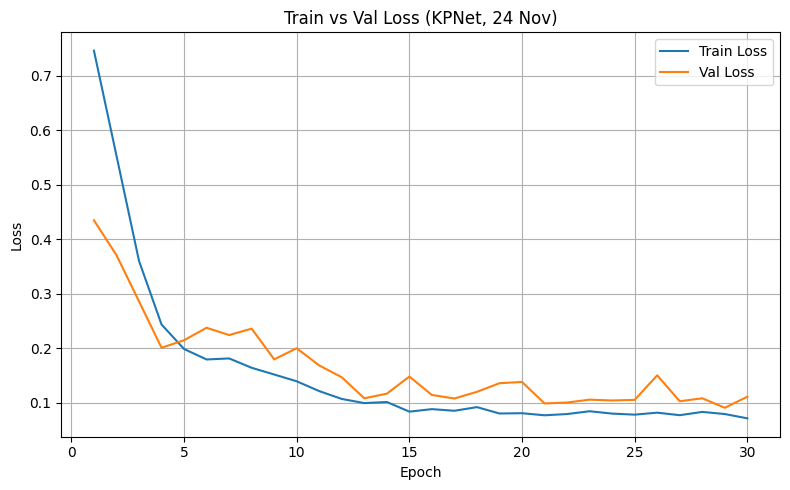

In [13]:
epochs = df["epoch"].values
train_loss = df["train_loss"].values
val_loss   = df["val_loss"].values

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss (KPNet, 24 Nov)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


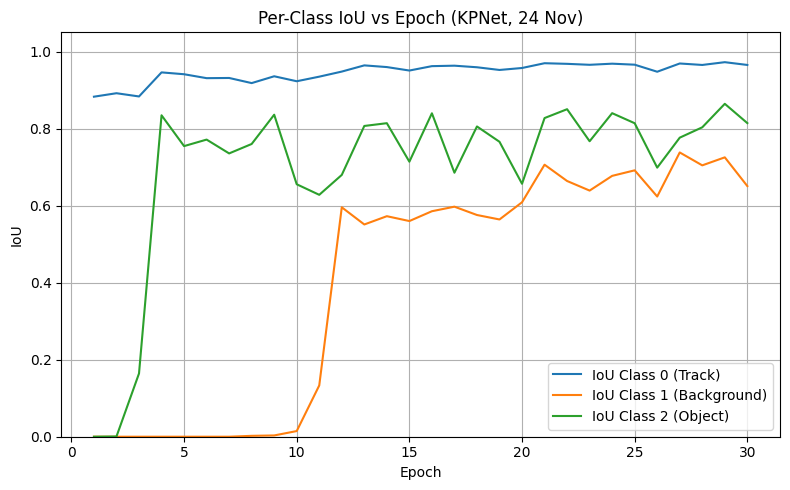

In [14]:
iou0 = df["iou0"].values  # Track
iou1 = df["iou1"].values  # Background
iou2 = df["iou2"].values  # Object

plt.figure(figsize=(8,5))
plt.plot(epochs, iou0, label="IoU Class 0 (Track)")
plt.plot(epochs, iou1, label="IoU Class 1 (Background)")
plt.plot(epochs, iou2, label="IoU Class 2 (Object)")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.ylim(0.0, 1.05)
plt.title("Per-Class IoU vs Epoch (KPNet, 24 Nov)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


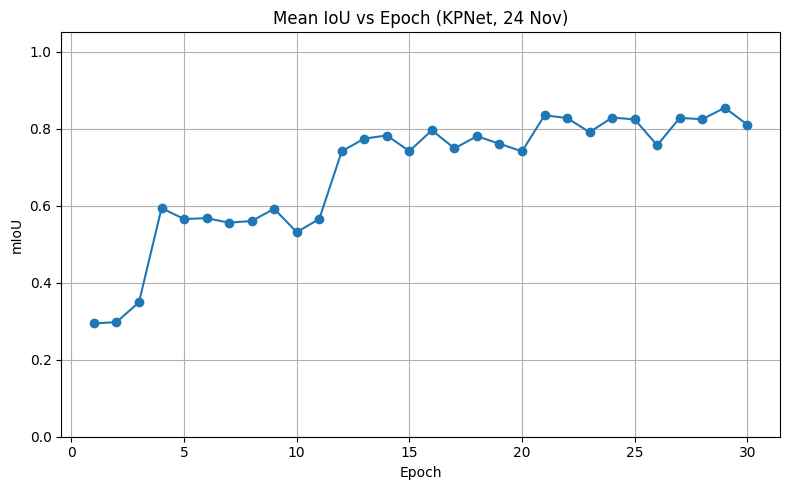

In [15]:
miou = df["miou"].values

plt.figure(figsize=(8,5))
plt.plot(epochs, miou, marker="o")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.ylim(0.0, 1.05)
plt.title("Mean IoU vs Epoch (KPNet, 24 Nov)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Rebuild model exactly like training
best_model = KPNet(base=8, num_classes=3, K=6).to(DEVICE)

best_ckpt_path = "./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.8541.pth"  # adjust if name slightly different
state_dict = torch.load(best_ckpt_path, map_location=DEVICE)
best_model.load_state_dict(state_dict)
best_model.eval()

print("Loaded best model from:", best_ckpt_path)


Loaded best model from: ./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.8541.pth


In [17]:
all_preds = []
all_labels = []

with torch.no_grad():
    for pts, lbl in val_loader:
        pts = pts.to(DEVICE)
        lbl = lbl.to(DEVICE)

        logits = best_model(pts)              # (B, P, 3)
        preds = logits.argmax(dim=-1)         # (B, P)

        all_preds.append(preds.cpu().numpy().reshape(-1))
        all_labels.append(lbl.cpu().numpy().reshape(-1))

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("Preds shape :", all_preds.shape)
print("Labels shape:", all_labels.shape)


Preds shape : (40960,)
Labels shape: (40960,)


Confusion matrix (counts):
 [[36200   198   100]
 [  143   973     9]
 [  597    19  2721]]


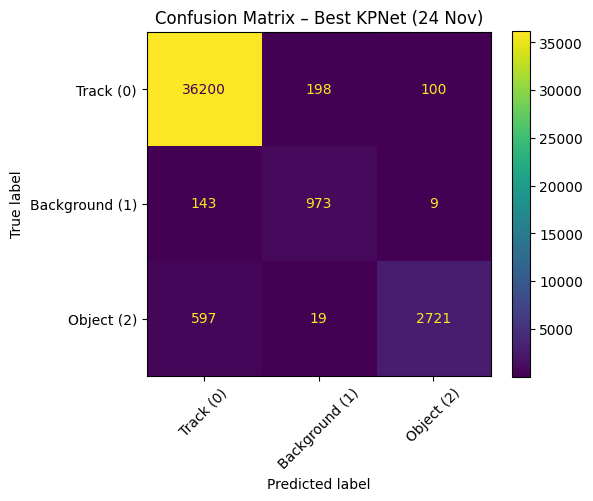

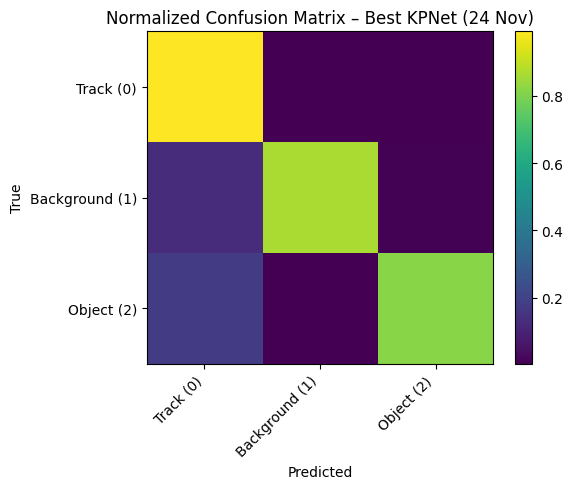

In [18]:
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
print("Confusion matrix (counts):\n", cm)

class_names = ["Track (0)", "Background (1)", "Object (2)"]

# Raw counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, values_format="d", xticks_rotation=45)
plt.title("Confusion Matrix – Best KPNet (24 Nov)")
plt.tight_layout()
plt.show()

# Normalized per true class
cm_norm = cm.astype(np.float32) / (cm.sum(axis=1, keepdims=True) + 1e-8)

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_norm, aspect="auto")
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Normalized Confusion Matrix – Best KPNet (24 Nov)")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


In [19]:
from plyfile import PlyData, PlyElement

def predict_ply_file(
    input_path,
    output_path,
    model,
    device=DEVICE,
    chunk_size=4096
):
    """
    input_path  : path to original .ply
    output_path : where to save .ply with predictions
    model       : trained KPNet model (in eval mode)
    """
    print(f"Reading PLY: {input_path}")
    pd = PlyData.read(str(input_path))
    v = pd["vertex"].data

    # Extract XYZ
    pts = np.vstack([v["x"], v["y"], v["z"]]).T.astype(np.float32)

    # Apply same centering as training
    pts_centered = pts - pts.mean(axis=0, keepdims=True)

    N = pts_centered.shape[0]
    preds_all = np.zeros(N, dtype=np.int64)

    model.eval()
    with torch.no_grad():
        start = 0
        while start < N:
            end = min(start + chunk_size, N)
            pts_chunk = pts_centered[start:end]            # (M,3)
            pts_tensor = torch.from_numpy(pts_chunk).unsqueeze(0).to(device)  # (1,M,3)

            logits = model(pts_tensor)                     # (1,M,3)
            preds = logits.argmax(dim=-1).cpu().numpy().reshape(-1)

            preds_all[start:end] = preds
            start = end

    print("Predictions done. Attaching to PLY...")

    # Add predictions as new property to vertex
    # Original vertex is a structured array; build new dtype with extra field
    old_vertex = v
    pred_field_name = "scalar_PredClass"

    new_dtype = old_vertex.dtype.descr + [(pred_field_name, "i4")]
    new_vertex = np.empty(old_vertex.shape, dtype=new_dtype)

    # Copy old fields
    for name in old_vertex.dtype.names:
        new_vertex[name] = old_vertex[name]

    # Add predictions
    new_vertex[pred_field_name] = preds_all.astype(np.int32)

    # Create new PlyElement and PlyData
    new_el = PlyElement.describe(new_vertex, "vertex")
    new_ply = PlyData([new_el], text=pd.text)

    print(f"Writing predicted PLY: {output_path}")
    new_ply.write(str(output_path))
    print("Done.")


In [21]:
from pathlib import Path

input_ply = Path("/home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi/Sphere_1_ascii_roi.ply")
print("Selected PLY:", input_ply)

# put output in your CAPSTONE_SSS_03/GPU folder
output_ply = Path("/home/ccbd/Desktop/SSS_03/CAPSTONE_SSS_03/GPU") / (input_ply.stem + "_pred_24nov.ply")
print("Output PLY:", output_ply)

predict_ply_file(
    input_path=input_ply,
    output_path=output_ply,
    model=best_model,
    device=DEVICE,
    chunk_size=4096
)


Selected PLY: /home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi/Sphere_1_ascii_roi.ply
Output PLY: /home/ccbd/Desktop/SSS_03/CAPSTONE_SSS_03/GPU/Sphere_1_ascii_roi_pred_24nov.ply
Reading PLY: /home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi/Sphere_1_ascii_roi.ply
Predictions done. Attaching to PLY...
Writing predicted PLY: /home/ccbd/Desktop/SSS_03/CAPSTONE_SSS_03/GPU/Sphere_1_ascii_roi_pred_24nov.ply
Done.


In [22]:
from plyfile import PlyData
import numpy as np

# ---- CHANGE THIS PATH ----
ply_path = "/home/ccbd/Desktop/SSS_03/CAPSTONE_SSS_03/GPU/Sphere_1_ascii_roi_pred_24nov.ply"

print("Reading:", ply_path)

ply = PlyData.read(ply_path)
vertex = ply['vertex'].data

# Access predicted labels
pred = np.array(vertex['scalar_PredClass'], dtype=np.float32)

# Convert to int (because stored as float)
pred_int = pred.astype(np.int32)

# Count occurrences
unique, counts = np.unique(pred_int, return_counts=True)

print("\nPredicted class distribution:")
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} points")

print("\nTotal points:", len(pred_int))


Reading: /home/ccbd/Desktop/SSS_03/CAPSTONE_SSS_03/GPU/Sphere_1_ascii_roi_pred_24nov.ply

Predicted class distribution:
  Class 0: 1269 points
  Class 2: 1339555 points

Total points: 1340824


In [23]:
from plyfile import PlyData
import numpy as np
from sklearn.metrics import confusion_matrix

# Paths
orig_path = "/home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi/Sphere_1_ascii_roi.ply"
pred_path = "/home/ccbd/Desktop/SSS_03/CAPSTONE_SSS_03/GPU/Sphere_1_ascii_roi_pred_24nov.ply"

print("Original PLY:", orig_path)
print("Pred PLY    :", pred_path)

# --- Read original (with GT labels) ---
orig_ply = PlyData.read(orig_path)
orig_v = orig_ply["vertex"].data

raw_labels = np.array(orig_v["scalar_NewClassification"])
label_map = {1: 0, 3: 1, 9: 2}

mapped = np.full(raw_labels.shape, -1, dtype=np.int32)
for k, v in label_map.items():
    mapped[raw_labels == k] = v

mask = mapped >= 0
gt = mapped[mask]

print("\nGT class distribution (after mapping 1→0, 3→1, 9→2):")
uniq_gt, cnt_gt = np.unique(gt, return_counts=True)
for u, c in zip(uniq_gt, cnt_gt):
    print(f"  GT Class {u}: {c} points")
print("  Total GT valid points:", gt.shape[0])

# --- Read predictions (from pred PLY) ---
pred_ply = PlyData.read(pred_path)
pred_v = pred_ply["vertex"].data

pred = np.array(pred_v["scalar_PredClass"], dtype=np.float32)
pred_int = pred.astype(np.int32)

# Align: use same mask as GT (ignore points that didn't have valid labels)
pred_valid = pred_int[mask]

print("\nPred class distribution (on GT-valid points only):")
uniq_p, cnt_p = np.unique(pred_valid, return_counts=True)
for u, c in zip(uniq_p, cnt_p):
    print(f"  Pred Class {u}: {c} points")
print("  Total Pred valid points:", pred_valid.shape[0])

# --- Confusion matrix for this single file ---
cm = confusion_matrix(gt, pred_valid, labels=[0,1,2])
print("\nConfusion matrix (rows=GT, cols=Pred, classes 0,1,2):\n", cm)


Original PLY: /home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi/Sphere_1_ascii_roi.ply
Pred PLY    : /home/ccbd/Desktop/SSS_03/CAPSTONE_SSS_03/GPU/Sphere_1_ascii_roi_pred_24nov.ply

GT class distribution (after mapping 1→0, 3→1, 9→2):
  GT Class 0: 1285526 points
  GT Class 1: 49063 points
  GT Class 2: 6235 points
  Total GT valid points: 1340824

Pred class distribution (on GT-valid points only):
  Pred Class 0: 1269 points
  Pred Class 2: 1339555 points
  Total Pred valid points: 1340824

Confusion matrix (rows=GT, cols=Pred, classes 0,1,2):
 [[   1268       0 1284258]
 [      1       0   49062]
 [      0       0    6235]]


In [24]:
import os
from pathlib import Path
import numpy as np
import torch
from plyfile import PlyData, PlyElement
from sklearn.metrics import confusion_matrix

# ---------------------
# Settings
# ---------------------
DATA_PATH = Path("/home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi")
ALL_FILES = sorted(DATA_PATH.glob("*.ply"))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Files found:", len(ALL_FILES))


# ---------------------------------------
# Helper: read GT and map labels
# ---------------------------------------
label_map = {1: 0, 3: 1, 9: 2}

def read_gt_labels(path):
    pd = PlyData.read(str(path))
    v = pd["vertex"].data

    lbl = np.array(v["scalar_NewClassification"]).astype(np.int64)
    lbl = np.vectorize(lambda x: label_map.get(int(x), 255))(lbl)

    mask = lbl != 255     # filter only valid labels
    return mask, lbl[mask]


# ---------------------------------------
# Helper: run model on full cloud (chunked)
# ---------------------------------------
def predict_xyz(model, xyz, chunk=4096):
    preds = []
    model.eval()

    with torch.no_grad():
        for i in range(0, len(xyz), chunk):
            part = xyz[i:i+chunk]
            part = torch.from_numpy(part).float().unsqueeze(0).to(DEVICE)
            logits = model(part)
            pred = logits.argmax(-1).squeeze(0).cpu().numpy()
            preds.append(pred)

    return np.concatenate(preds)


# ---------------------------------------
# MAIN LOOP
# ---------------------------------------
results = []

for path in ALL_FILES:
    print(f"\nProcessing tile: {path.name}")

    pd = PlyData.read(str(path))
    v = pd["vertex"].data
    xyz = np.vstack([v["x"], v["y"], v["z"]]).T.astype(np.float32)

    # get GT
    valid_mask, gt = read_gt_labels(path)
    xyz_valid = xyz[valid_mask]

    # predict on full cloud
    pred = predict_xyz(best_model, xyz_valid)

    # confusion matrix
    cm = confusion_matrix(gt, pred, labels=[0,1,2])

    # IoU calculation
    ious = []
    for c in range(3):
        tp = cm[c,c]
        fp = cm[:,c].sum() - tp
        fn = cm[c,:].sum() - tp
        denom = tp + fp + fn
        iou = tp/denom if denom > 0 else 0
        ious.append(iou)

    miou = np.mean(ious)

    print("IoUs:", ious, "   mIoU =", miou)

    results.append([path.name] + ious + [miou])


# ---------------------------------------
# Save CSV
# ---------------------------------------
import csv

csv_path = "full_tile_results.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["filename", "iou0", "iou1", "iou2", "miou"])
    w.writerows(results)

print("\nSaved:", csv_path)


Files found: 16

Processing tile: Sphere_10_ascii_roi.ply
IoUs: [np.float64(0.0), np.float64(0.0), np.float64(0.27364560479592487)]    mIoU = 0.09121520159864162

Processing tile: Sphere_11_ascii_roi.ply
IoUs: [np.float64(0.0), np.float64(0.0), np.float64(0.20473619798957782)]    mIoU = 0.06824539932985928

Processing tile: Sphere_12_ascii_roi.ply
IoUs: [np.float64(0.0), np.float64(0.0), np.float64(0.21446839860078368)]    mIoU = 0.07148946620026123

Processing tile: Sphere_13_ascii_roi.ply
IoUs: [np.float64(0.0), np.float64(0.0), np.float64(0.013852863843092667)]    mIoU = 0.004617621281030889

Processing tile: Sphere_14_ascii_roi.ply
IoUs: [np.float64(0.0), np.float64(0.0), np.float64(0.006073784296690336)]    mIoU = 0.0020245947655634453

Processing tile: Sphere_15_ascii_roi.ply
IoUs: [np.float64(0.0), np.float64(0.0), np.float64(0.007715208340284807)]    mIoU = 0.0025717361134282688

Processing tile: Sphere_16_ascii_roi.ply
IoUs: [np.float64(0.0), np.float64(0.0), np.float64(0.0100

In [25]:
# # CELL 6 — BEST TRAINING LOOP WITH TQDM (old version)

# from tqdm import tqdm

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()

# def compute_iou(pred, gt, nc):
#     from sklearn.metrics import confusion_matrix
#     cm = confusion_matrix(gt, pred, labels=list(range(nc)))
#     ious = []
#     for i in range(nc):
#         tp = cm[i,i]
#         fp = cm[:,i].sum() - tp
#         fn = cm[i,:].sum() - tp
#         denom = tp + fp + fn
#         ious.append(tp / denom if denom > 0 else 0)
#     return np.array(ious)

# EPOCHS = 10
# best_miou = 0

# for ep in range(EPOCHS):
#     model.train()
#     loop = tqdm(train_loader, desc=f"Epoch {ep+1}/{EPOCHS}", leave=True)

#     for pts, lbl in loop:
#         pts, lbl = pts.to(DEVICE), lbl.to(DEVICE)

#         optimizer.zero_grad()
#         logits = model(pts)
#         loss = criterion(logits.view(-1,3), lbl.view(-1))
#         loss.backward()
#         optimizer.step()

#         loop.set_postfix(loss=loss.item())

#     # Validation
#     model.eval()
#     preds_all, lbl_all = [], []
#     with torch.no_grad():
#         for pts, lbl in val_loader:
#             pts = pts.to(DEVICE)
#             logits = model(pts)
#             pred = logits.argmax(-1).cpu().numpy().reshape(-1)
#             lbl = lbl.numpy().reshape(-1)
#             preds_all.append(pred)
#             lbl_all.append(lbl)

#     preds_all = np.concatenate(preds_all)
#     lbl_all = np.concatenate(lbl_all)
#     iou = compute_iou(preds_all, lbl_all, 3)
#     miou = iou.mean()

#     print(f"\nEpoch {ep+1} → mIoU={miou:.4f} | IoUs={iou}")

#     if miou > best_miou:
#         best_miou = miou
#         torch.save(model.state_dict(), "best_kpconv.pth")
#         print("Saved BEST model!")

# print("\nTRAINING DONE.")
# print("Best mIoU achieved:", best_miou)


# Updated method than above for better predictions

In [26]:
# CELL 4 — PLY Dataset Loader (for your 3-class dataset)

import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path
from plyfile import PlyData

DATA_DIR = Path("/home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi")

label_map = {1: 0, 3: 1, 9: 2}   # final correct mapping

def read_ply_hungary(path):
    pd = PlyData.read(str(path))
    v = pd["vertex"].data

    pts = np.vstack([v["x"], v["y"], v["z"]]).T.astype(np.float32)
    labels = np.array(v["scalar_NewClassification"]).astype(np.int64)

    # remap labels
    labels = np.vectorize(lambda x: label_map.get(int(x), 255))(labels)
    mask = labels != 255
    return pts[mask], labels[mask]

class HungaryPLYDataset(Dataset):
    def __init__(self, root, files, points_per_sample=2048, augment=True):
        self.root = Path(root)
        self.files = files
        self.points_per_sample = points_per_sample
        self.augment = augment

    def __len__(self):
        return len(self.files) * 10

    def __getitem__(self, idx):
        ply = self.files[np.random.randint(len(self.files))]
        pts, labels = read_ply_hungary(self.root / ply)

        N = len(pts)
        P = self.points_per_sample
        idxs = np.random.choice(N, P, replace=(N < P))

        pts = pts[idxs]
        labels = labels[idxs]

        if self.augment:
            theta = np.random.uniform(0, 2 * np.pi)
            R = np.array([
                [np.cos(theta), -np.sin(theta), 0],
                [np.sin(theta),  np.cos(theta), 0],
                [0, 0, 1]
            ], dtype=np.float32)
            pts = pts @ R.T
            pts += np.random.normal(0, 0.01, pts.shape)

        pts -= pts.mean(0, keepdims=True)

        return torch.from_numpy(pts), torch.from_numpy(labels)

def collate_batch(batch):
    pts = torch.stack([b[0] for b in batch], dim=0)
    lbl = torch.stack([b[1] for b in batch], dim=0)
    return pts, lbl

# Create train/val split
all_files = sorted([f.name for f in DATA_DIR.glob("*.ply")])
import random
random.shuffle(all_files)
N = len(all_files)
train_files = all_files[:int(0.8*N)]
val_files = all_files[int(0.8*N):]




train_ds = HungaryPLYDataset(DATA_DIR, train_files, points_per_sample=1024, augment=True)
val_ds   = HungaryPLYDataset(DATA_DIR, val_files,   points_per_sample=1024, augment=False)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,
                          num_workers=0, collate_fn=collate_batch, pin_memory=True)

val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False,
                          num_workers=0, collate_fn=collate_batch, pin_memory=True)
print("train batches:", len(train_loader), "val batches:", len(val_loader))


train batches: 120 val batches: 40


In [ ]:
#cell6 new version
# --- IMPORTS ---
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import os
from sklearn.metrics import confusion_matrix

# --- SETUP ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SAVE_DIR = "./checkpoints_kpconv_24nov"
os.makedirs(SAVE_DIR, exist_ok=True)

LOG_FILE = os.path.join(SAVE_DIR, "training_log_24nov.csv")

# create log header
with open(LOG_FILE, "w") as f:
    f.write("epoch,train_loss,val_loss,iou0,iou1,iou2,miou\n")


# --- IoU Function ---
def compute_iou(pred, gt, nc):
    cm = confusion_matrix(gt, pred, labels=list(range(nc)))
    ious = []
    for i in range(nc):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        denom = tp + fp + fn
        ious.append(tp / denom if denom > 0 else 0)
    return np.array(ious)


# --- MODEL, OPT, LOSS ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 30        # train longer than before
best_miou = 0.0


# --- TRAINING LOOP ---
for ep in range(EPOCHS):

    # ========== TRAIN ==========
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {ep+1}/{EPOCHS}", leave=True)
    total_train_loss = 0
    batches = 0

    for pts, lbl in loop:
        pts, lbl = pts.to(DEVICE), lbl.to(DEVICE)

        optimizer.zero_grad()
        logits = model(pts)
        loss = criterion(logits.view(-1,3), lbl.view(-1))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        batches += 1
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / batches

    # ========== VALIDATION ==========
    model.eval()
    preds_all, lbl_all = [], []
    total_val_loss = 0
    val_batches = 0

    with torch.no_grad():
        for pts, lbl in val_loader:
            pts = pts.to(DEVICE)
            lbl = lbl.to(DEVICE)
            logits = model(pts)

            loss = criterion(logits.view(-1,3), lbl.view(-1))
            total_val_loss += loss.item()
            val_batches += 1

            pred = logits.argmax(-1).cpu().numpy().reshape(-1)
            lbl_np = lbl.cpu().numpy().reshape(-1)

            preds_all.append(pred)
            lbl_all.append(lbl_np)

    avg_val_loss = total_val_loss / val_batches

    preds_all = np.concatenate(preds_all)
    lbl_all = np.concatenate(lbl_all)

    iou = compute_iou(preds_all, lbl_all, 3)
    miou = iou.mean()

    print(f"\nEpoch {ep+1} Summary:")
    print(f"  Train Loss = {avg_train_loss:.4f}")
    print(f"  Val Loss   = {avg_val_loss:.4f}")
    print(f"  IoU        = {iou}")
    print(f"  mIoU       = {miou:.4f}")

    # ----- SAVE LOG -----
    with open(LOG_FILE, "a") as f:
        f.write(f"{ep+1},{avg_train_loss:.4f},{avg_val_loss:.4f},{iou[0]:.4f},{iou[1]:.4f},{iou[2]:.4f},{miou:.4f}\n")

    # ----- SAVE BEST MODEL -----
    if miou > best_miou:
        best_miou = miou
        best_path = os.path.join(SAVE_DIR, f"best_model_24nov_mIoU_{best_miou:.4f}.pth")
        torch.save(model.state_dict(), best_path)
        print(f"  ✅ Saved BEST model to {best_path}")

    # ----- OPTIONAL: SAVE EVERY CHECKPOINT -----
    ckpt_path = os.path.join(SAVE_DIR, f"checkpoint_epoch_{ep+1}_24nov.pth")
    torch.save(model.state_dict(), ckpt_path)


print("\n🎉 TRAINING COMPLETE!")
print("Best mIoU =", best_miou)


In [ ]:
from plyfile import PlyData
import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path

DATA_DIR = Path("/home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi")

label_map = {1: 0, 3: 1, 9: 2}   # same mapping

def read_ply_xyz_labels(path):
    pd = PlyData.read(str(path))
    v  = pd["vertex"].data

    xyz = np.vstack([v["x"], v["y"], v["z"]]).T.astype(np.float32)
    raw = np.array(v["scalar_NewClassification"]).astype(np.int64)

    lbl = np.vectorize(lambda x: label_map.get(int(x), 255))(raw)
    mask = lbl != 255

    xyz = xyz[mask]
    lbl = lbl[mask]
    return xyz, lbl


class FullCloudChunkDataset(Dataset):
    """
    Takes each PLY, splits into sequential chunks of `points_per_chunk`.
    No synthetic balancing, just real-class distribution.
    """

    def __init__(self, root, files, points_per_chunk=4096, augment=True):
        self.root = Path(root)
        self.files = files
        self.points_per_chunk = points_per_chunk
        self.augment = augment

        # Precompute (file_index, start_idx, end_idx) for all chunks
        self.chunks = []  # list of (file_path, start_idx, end_idx)

        for f in self.files:
            path = self.root / f
            xyz, lbl = read_ply_xyz_labels(path)
            N = xyz.shape[0]

            # chunk boundaries
            for start in range(0, N, points_per_chunk):
                end = min(start + points_per_chunk, N)
                if end - start < 512:
                    # skip tiny tail chunk to keep batches reasonable
                    continue
                self.chunks.append((path, start, end))

        print(f"[FullCloudChunkDataset] Total chunks: {len(self.chunks)}")

    def __len__(self):
        return len(self.chunks)

    def _augment(self, xyz):
        # rotation around Z + small jitter (same style as before)
        xyz = xyz.copy()
        theta = np.random.uniform(0, 2*np.pi)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s, 0],
                      [s,  c, 0],
                      [0,  0, 1]], dtype=np.float32)
        xyz = xyz @ R.T
        xyz += np.random.normal(0, 0.01, xyz.shape).astype(np.float32)
        return xyz

    def __getitem__(self, idx):
        path, start, end = self.chunks[idx]
        xyz, lbl = read_ply_xyz_labels(path)   # reload (simple & robust)

        xyz = xyz[start:end]
        lbl = lbl[start:end]

        # center (same as your previous pipeline)
        xyz = xyz - xyz.mean(axis=0, keepdims=True)

        if self.augment:
            xyz = self._augment(xyz)

        xyz_t = torch.from_numpy(xyz).float()        # (M,3)
        lbl_t = torch.from_numpy(lbl).long()         # (M,)

        return xyz_t, lbl_t


In [ ]:
from torch.utils.data import DataLoader
import random

# Collect all PLY files
all_files = sorted([f.name for f in DATA_DIR.glob("*.ply")])
random.shuffle(all_files)

N = len(all_files)
train_files = all_files[:int(0.8 * N)]
val_files   = all_files[int(0.8 * N):]

print("Train files:", len(train_files), " Val files:", len(val_files))

# Datasets using full-cloud chunks
train_ds_25 = FullCloudChunkDataset(
    root=DATA_DIR,
    files=train_files,
    points_per_chunk=4096,
    augment=True
)

val_ds_25 = FullCloudChunkDataset(
    root=DATA_DIR,
    files=val_files,
    points_per_chunk=4096,
    augment=False
)

train_loader = DataLoader(
    train_ds_25,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds_25,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("train batches:", len(train_loader), " val batches:", len(val_loader))


In [ ]:
#training loop new version
# --- IMPORTS ---
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import os
from sklearn.metrics import confusion_matrix

# --- SETUP ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ NEW: separate folder for today
SAVE_DIR = "./checkpoints_kpconv_25nov"
os.makedirs(SAVE_DIR, exist_ok=True)

# ✅ NEW: log file with 25nov suffix
LOG_FILE = os.path.join(SAVE_DIR, "training_log_25nov.csv")

# create log header
with open(LOG_FILE, "w") as f:
    f.write("epoch,train_loss,val_loss,iou0,iou1,iou2,miou\n")


# --- IoU Function (same as before) ---
def compute_iou(pred, gt, nc):
    cm = confusion_matrix(gt, pred, labels=list(range(nc)))
    ious = []
    for i in range(nc):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        denom = tp + fp + fn
        ious.append(tp / denom if denom > 0 else 0)
    return np.array(ious)


# --- MODEL, OPT, LOSS ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 30
best_miou = 0.0


# --- TRAINING LOOP ---
for ep in range(EPOCHS):

    # ========== TRAIN ==========
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {ep+1}/{EPOCHS}", leave=True)
    total_train_loss = 0
    batches = 0

    for pts, lbl in loop:
        pts, lbl = pts.to(DEVICE), lbl.to(DEVICE)

        optimizer.zero_grad()
        logits = model(pts)
        loss = criterion(logits.view(-1,3), lbl.view(-1))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        batches += 1
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / batches

    # ========== VALIDATION ==========
    model.eval()
    preds_all, lbl_all = [], []
    total_val_loss = 0
    val_batches = 0

    with torch.no_grad():
        for pts, lbl in val_loader:
            pts = pts.to(DEVICE)
            lbl = lbl.to(DEVICE)
            logits = model(pts)

            loss = criterion(logits.view(-1,3), lbl.view(-1))
            total_val_loss += loss.item()
            val_batches += 1

            pred = logits.argmax(-1).cpu().numpy().reshape(-1)
            lbl_np = lbl.cpu().numpy().reshape(-1)

            preds_all.append(pred)
            lbl_all.append(lbl_np)

    avg_val_loss = total_val_loss / val_batches

    preds_all = np.concatenate(preds_all)
    lbl_all = np.concatenate(lbl_all)

    iou = compute_iou(preds_all, lbl_all, 3)
    miou = iou.mean()

    print(f"\nEpoch {ep+1} Summary:")
    print(f"  Train Loss = {avg_train_loss:.4f}")
    print(f"  Val Loss   = {avg_val_loss:.4f}")
    print(f"  IoU        = {iou}")
    print(f"  mIoU       = {miou:.4f}")

    # ----- SAVE LOG -----
    with open(LOG_FILE, "a") as f:
        f.write(
            f"{ep+1},{avg_train_loss:.4f},{avg_val_loss:.4f},"
            f"{iou[0]:.4f},{iou[1]:.4f},{iou[2]:.4f},{miou:.4f}\n"
        )

    # ----- SAVE BEST MODEL (with 25nov tag) -----
    if miou > best_miou:
        best_miou = miou
        best_path = os.path.join(SAVE_DIR, f"best_model_25nov_mIoU_{best_miou:.4f}.pth")
        torch.save(model.state_dict(), best_path)
        print(f"  ✅ Saved BEST model to {best_path}")

    # ----- OPTIONAL: SAVE EVERY CHECKPOINT (with 25nov) -----
    ckpt_path = os.path.join(SAVE_DIR, f"checkpoint_epoch_{ep+1}_25nov.pth")
    torch.save(model.state_dict(), ckpt_path)

print("\n🎉 TRAINING COMPLETE!")
print("Best mIoU =", best_miou)


In [ ]:
import os
from pathlib import Path
import numpy as np
import torch
from plyfile import PlyData
from sklearn.metrics import confusion_matrix
import csv

# ---------------------
# Paths & model
# ---------------------
DATA_PATH = Path("/home/ccbd/Desktop/SSS_03/Data/train_sphere_ascii_roi")
ALL_FILES = sorted(DATA_PATH.glob("*.ply"))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Files found:", len(ALL_FILES))

# ✅ use your new best model if you retrain:
# best_ckpt_path = "./checkpoints_kpconv_25nov/best_model_25nov_mIoU_0.xxxx.pth"
# or keep the old 24nov one for comparison:
best_ckpt_path = "./checkpoints_kpconv_24nov/best_model_24nov_mIoU_0.8541.pth"

best_model = KPNet(base=8, num_classes=3, K=6).to(DEVICE)
best_model.load_state_dict(torch.load(best_ckpt_path, map_location=DEVICE))
best_model.eval()
print("Loaded:", best_ckpt_path)


# ---------------------------------------
# Helper: read GT and map labels
# ---------------------------------------
label_map = {1: 0, 3: 1, 9: 2}

def read_gt_labels(path):
    pd = PlyData.read(str(path))
    v = pd["vertex"].data

    lbl = np.array(v["scalar_NewClassification"]).astype(np.int64)
    lbl = np.vectorize(lambda x: label_map.get(int(x), 255))(lbl)

    mask = lbl != 255
    return mask, lbl[mask]


# ---------------------------------------
# Helper: run model on full cloud (chunked)
# ---------------------------------------
def predict_xyz(model, xyz, chunk=4096):
    preds = []
    model.eval()

    with torch.no_grad():
        for i in range(0, len(xyz), chunk):
            part = xyz[i:i+chunk]
            part = torch.from_numpy(part).float().unsqueeze(0).to(DEVICE)
            logits = model(part)
            pred = logits.argmax(-1).squeeze(0).cpu().numpy()
            preds.append(pred)

    return np.concatenate(preds)


# ---------------------------------------
# MAIN LOOP
# ---------------------------------------
results = []

for path in ALL_FILES:
    print(f"\nProcessing tile: {path.name}")

    pd = PlyData.read(str(path))
    v = pd["vertex"].data
    xyz = np.vstack([v["x"], v["y"], v["z"]]).T.astype(np.float32)

    valid_mask, gt = read_gt_labels(path)
    xyz_valid = xyz[valid_mask]

    # 🔹 Keep a similar normalization scheme (optional, but safe & consistent)
    xyz_valid = xyz_valid - xyz_valid.mean(axis=0, keepdims=True)

    pred = predict_xyz(best_model, xyz_valid)

    cm = confusion_matrix(gt, pred, labels=[0,1,2])

    ious = []
    for c in range(3):
        tp = cm[c,c]
        fp = cm[:,c].sum() - tp
        fn = cm[c,:].sum() - tp
        denom = tp + fp + fn
        iou = tp/denom if denom > 0 else 0
        ious.append(iou)

    miou = float(np.mean(ious))
    print("IoUs:", ious, "   mIoU =", miou)

    results.append([path.name] + ious + [miou])


# ---------------------------------------
# ✅ Save CSV in a 25nov-specific folder
# ---------------------------------------
EVAL_DIR = "./eval_fulltiles_25nov"
os.makedirs(EVAL_DIR, exist_ok=True)

csv_path = os.path.join(EVAL_DIR, "full_tile_results_25nov.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["filename", "iou0", "iou1", "iou2", "miou"])
    w.writerows(results)

print("\nSaved:", csv_path)
